In [1]:
import sys
sys.path.append('..')

In [2]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [3]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [4]:
series_data = BuiltInSeriesData()

+---+----------------------+----------------------------------------------+
|   | table's name         | table's columns                              |
+---+----------------------+----------------------------------------------+
| 0 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 1 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 2 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 3 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT |
| 4 | Electric_Production  | date, value                                  |
| 5 | Messages_Sent        | date, ta, tb, tc                             |
| 6 | Messages_Sent_Hour   | date, hour, ta, tb, tc                       |
| 7 | Supermarket_Incoming | date, goods_cnt                              |
| 8 | Web_Sales            | date, type_a, type_b, sales_cnt              |
+---+----------------------+----------------------------------------------+


In [5]:
cs = series_data[4]

x_train, x_test, y_train, y_test = split_series(cs['value'], cs['value'], 128, 24, train_size=0.9)

In [6]:
x_train.shape, x_test.shape

((221, 128), (25, 128))

In [23]:
from spinesTS.preprocessing import lag_splits
lag_splits([1, 2, 3, 4, 5, 6, 7, 8, 9, None, None, None], window_size=3, skip_steps=1, pred_steps=1)

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9],
       [8, 9, None],
       [9, None, None],
       [None, None, None]], dtype=object)

In [15]:
cs.tail(30)

,date,value
367,08-01-2015,110.5925
368,09-01-2015,101.9204
369,10-01-2015,91.5959
370,11-01-2015,93.0628
371,12-01-2015,103.2203
372,01-01-2016,117.0837
373,02-01-2016,106.6688
374,03-01-2016,95.3548
375,04-01-2016,89.3254
376,05-01-2016,90.7369


# StackingRNN

Using cpu backend
Epoch 1/3000  Loss_Fn mae
7/7 - p0 - loss: 100.6524 - mae: 95.8954 - val_loss: 99.0783 - val_mae: 99.0783 - 0.17s/epoch - 0.024s/step
Epoch 2/3000  Loss_Fn mae
7/7 - p0 - loss: 79.9002 - mae: 85.3479 - val_loss: 73.7713 - val_mae: 73.7713 - 0.16s/epoch - 0.023s/step
Epoch 3/3000  Loss_Fn mae
7/7 - p0 - loss: 19.5306 - mae: 43.5338 - val_loss: 9.3800 - val_mae: 9.3800 - 0.15s/epoch - 0.022s/step
Epoch 4/3000  Loss_Fn mae
7/7 - p1 - loss: 16.2250 - mae: 17.5412 - val_loss: 13.2010 - val_mae: 13.2010 - 0.15s/epoch - 0.022s/step
Epoch 5/3000  Loss_Fn mae
7/7 - p2 - loss: 13.3355 - mae: 14.2931 - val_loss: 12.5486 - val_mae: 12.5486 - 0.15s/epoch - 0.021s/step
Epoch 6/3000  Loss_Fn mae
7/7 - p0 - loss: 7.9578 - mae: 8.2496 - val_loss: 8.5589 - val_mae: 8.5589 - 0.16s/epoch - 0.023s/step
Epoch 7/3000  Loss_Fn mae
7/7 - p1 - loss: 7.8424 - mae: 12.9607 - val_loss: 8.5848 - val_mae: 8.5848 - 0.15s/epoch - 0.021s/step
Epoch 8/3000  Loss_Fn mae
7/7 - p2 - loss: 15.1988 - mae: 1

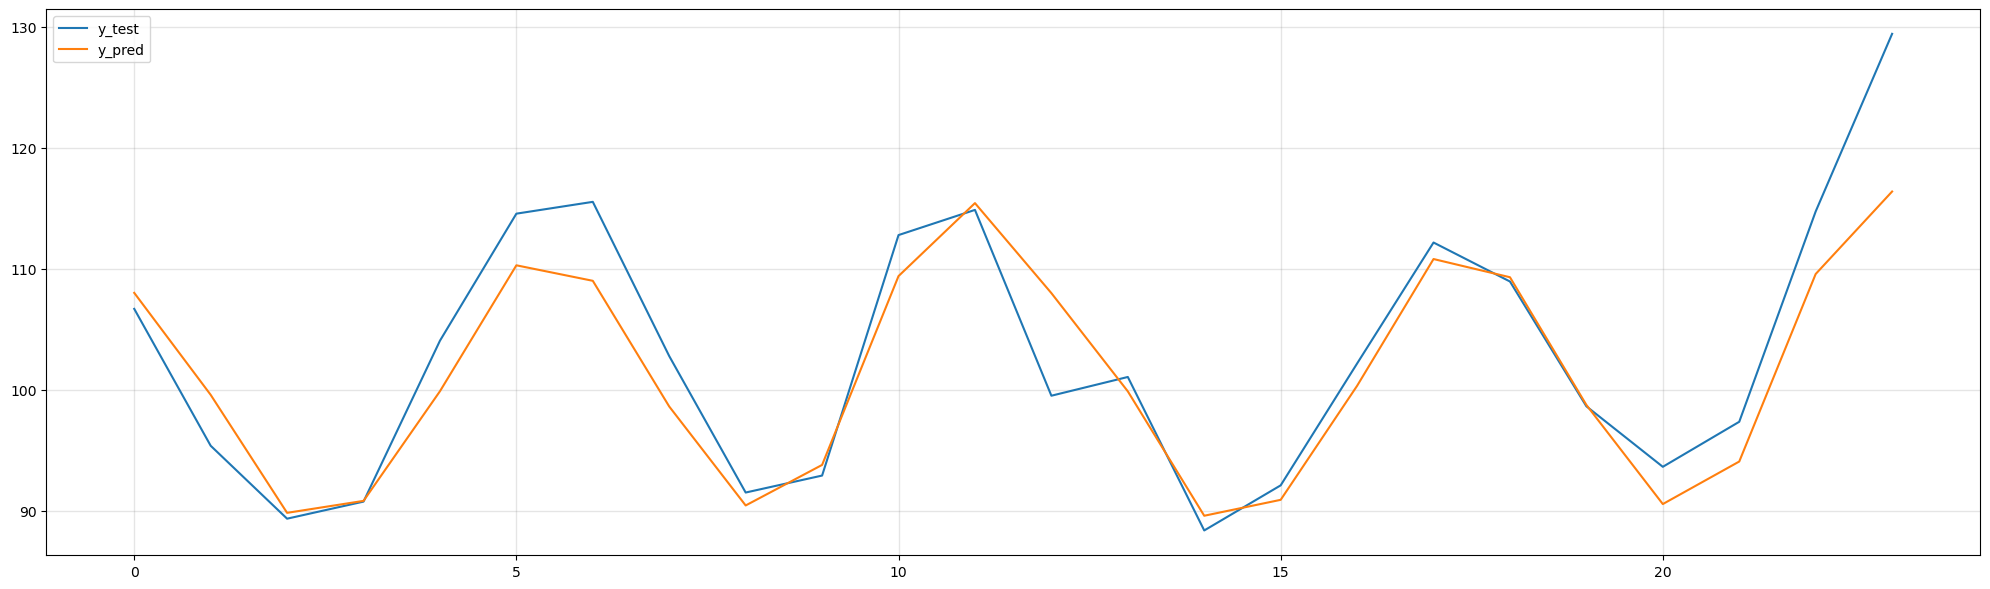

In [8]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1, diff_n=1, 
                    stack_num=2, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  Loss_Fn mse
7/7 - p0 - loss: 49.7529 - mae: 76.5264 - val_loss: 44.4227 - val_mae: 44.9168 - 0.08s/epoch - 0.012s/step
Epoch 2/3000  Loss_Fn mse
7/7 - p0 - loss: 23.6905 - mae: 28.1966 - val_loss: 23.6319 - val_mae: 24.1239 - 0.07s/epoch - 0.010s/step
Epoch 3/3000  Loss_Fn mse
7/7 - p0 - loss: 20.3820 - mae: 19.3414 - val_loss: 20.8389 - val_mae: 21.3304 - 0.07s/epoch - 0.010s/step
Epoch 4/3000  Loss_Fn mse
7/7 - p0 - loss: 13.6176 - mae: 15.1253 - val_loss: 14.5765 - val_mae: 15.0705 - 0.08s/epoch - 0.011s/step
Epoch 5/3000  Loss_Fn mse
7/7 - p0 - loss: 14.0731 - mae: 14.1816 - val_loss: 14.2694 - val_mae: 14.7609 - 0.07s/epoch - 0.010s/step
Epoch 6/3000  Loss_Fn mse
7/7 - p0 - loss: 13.1393 - mae: 11.9167 - val_loss: 13.0846 - val_mae: 13.5788 - 0.07s/epoch - 0.010s/step
Epoch 7/3000  Loss_Fn mse
7/7 - p1 - loss: 12.8961 - mae: 11.4483 - val_loss: 13.1241 - val_mae: 13.6152 - 0.07s/epoch - 0.009s/step
Epoch 8/3000  Loss_Fn mse
7/7 - p0 - loss: 11.3009 

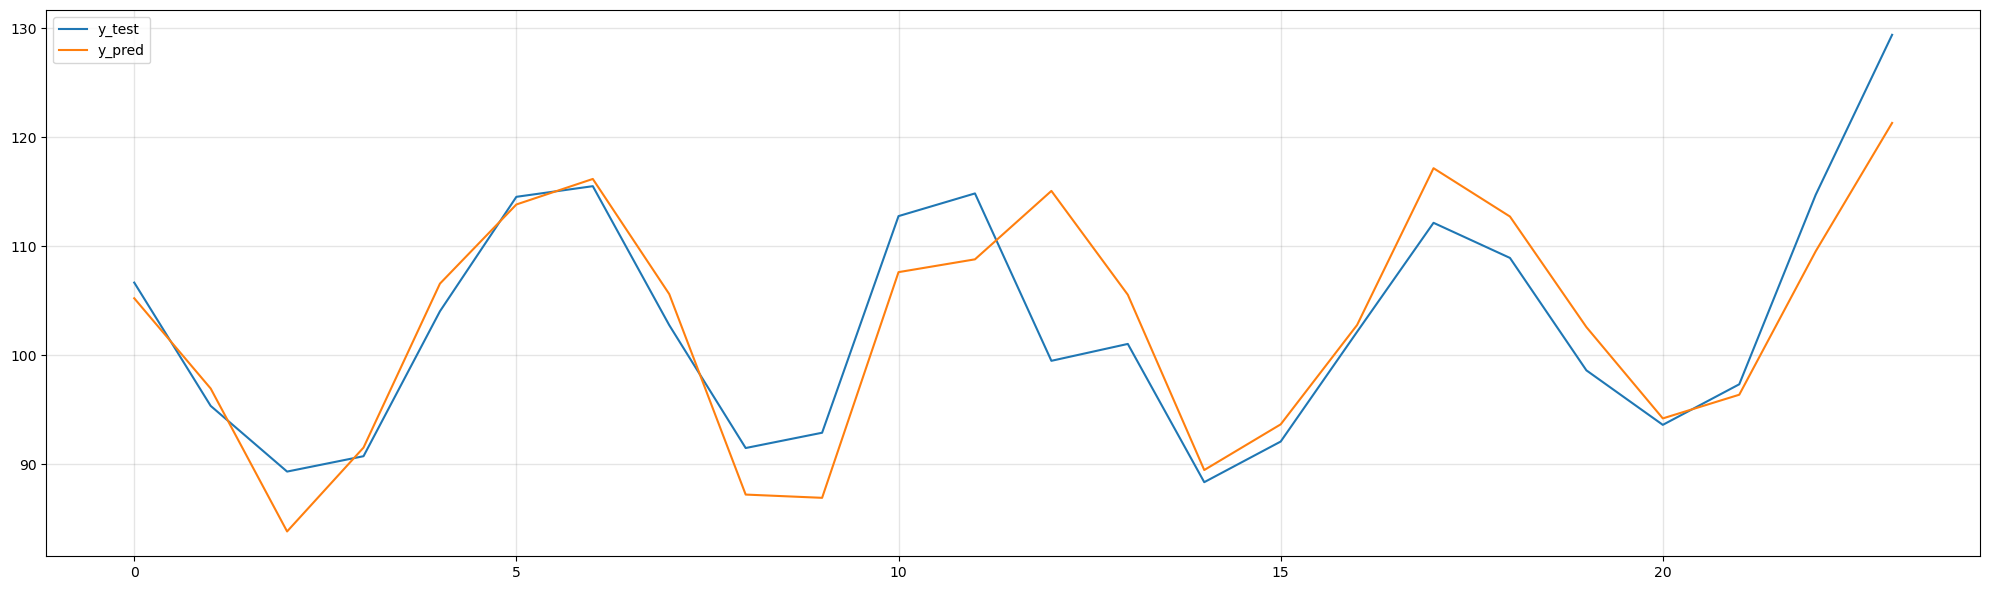

In [10]:
model = GAUNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, level=5, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

Using mps backend
Epoch 1/3000  Loss_Fn mse
7/7 - p0 - loss: 92.4849 - mae: 91.8933 - val_loss: 90.3742 - val_mae: 90.8742 - 0.58s/epoch - 0.083s/step
Epoch 2/3000  Loss_Fn mse
7/7 - p0 - loss: 82.1199 - mae: 82.3168 - val_loss: 79.9990 - val_mae: 80.4990 - 0.32s/epoch - 0.046s/step
Epoch 3/3000  Loss_Fn mse
7/7 - p0 - loss: 72.5893 - mae: 73.5553 - val_loss: 70.4216 - val_mae: 70.9216 - 0.31s/epoch - 0.045s/step
Epoch 4/3000  Loss_Fn mse
7/7 - p0 - loss: 63.5707 - mae: 65.3550 - val_loss: 61.3235 - val_mae: 61.8235 - 0.31s/epoch - 0.045s/step
Epoch 5/3000  Loss_Fn mse
7/7 - p0 - loss: 54.7692 - mae: 57.4550 - val_loss: 52.3874 - val_mae: 52.8874 - 0.32s/epoch - 0.045s/step
Epoch 6/3000  Loss_Fn mse
7/7 - p0 - loss: 45.9241 - mae: 49.5983 - val_loss: 43.3660 - val_mae: 43.8660 - 0.32s/epoch - 0.045s/step
Epoch 7/3000  Loss_Fn mse
7/7 - p0 - loss: 36.8699 - mae: 41.6345 - val_loss: 34.1637 - val_mae: 34.6637 - 0.32s/epoch - 0.046s/step
Epoch 8/3000  Loss_Fn mse
7/7 - p0 - loss: 27.5119 

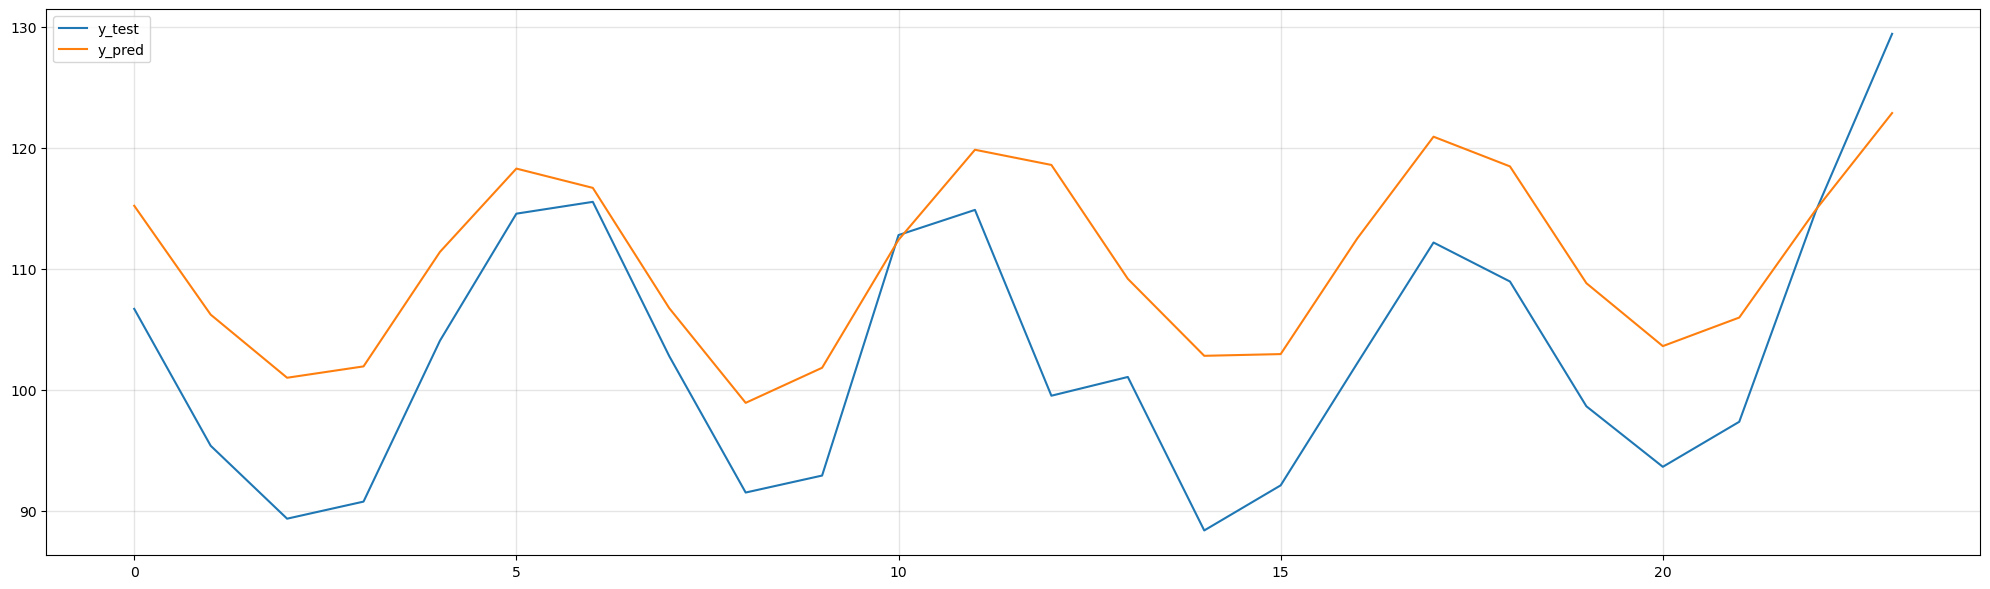

In [8]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='mps')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using cpu backend
Epoch 1/3000  Loss_Fn mse
7/7 - p0 - loss: 92.4849 - mae: 91.8933 - val_loss: 90.3743 - val_mae: 90.8743 - 0.03s/epoch - 0.005s/step
Epoch 2/3000  Loss_Fn mse
7/7 - p0 - loss: 82.1206 - mae: 82.3171 - val_loss: 80.0004 - val_mae: 80.5004 - 0.03s/epoch - 0.004s/step
Epoch 3/3000  Loss_Fn mse
7/7 - p0 - loss: 72.5930 - mae: 73.5561 - val_loss: 70.4220 - val_mae: 70.9220 - 0.02s/epoch - 0.003s/step
Epoch 4/3000  Loss_Fn mse
7/7 - p0 - loss: 63.5788 - mae: 65.3545 - val_loss: 61.3227 - val_mae: 61.8227 - 0.02s/epoch - 0.003s/step
Epoch 5/3000  Loss_Fn mse
7/7 - p0 - loss: 54.7649 - mae: 57.4546 - val_loss: 52.3984 - val_mae: 52.8984 - 0.02s/epoch - 0.003s/step
Epoch 6/3000  Loss_Fn mse
7/7 - p0 - loss: 45.9331 - mae: 49.6004 - val_loss: 43.3767 - val_mae: 43.8767 - 0.02s/epoch - 0.003s/step
Epoch 7/3000  Loss_Fn mse
7/7 - p0 - loss: 36.8619 - mae: 41.6329 - val_loss: 34.1565 - val_mae: 34.6565 - 0.02s/epoch - 0.003s/step
Epoch 8/3000  Loss_Fn mse
7/7 - p0 - loss: 27.5153 

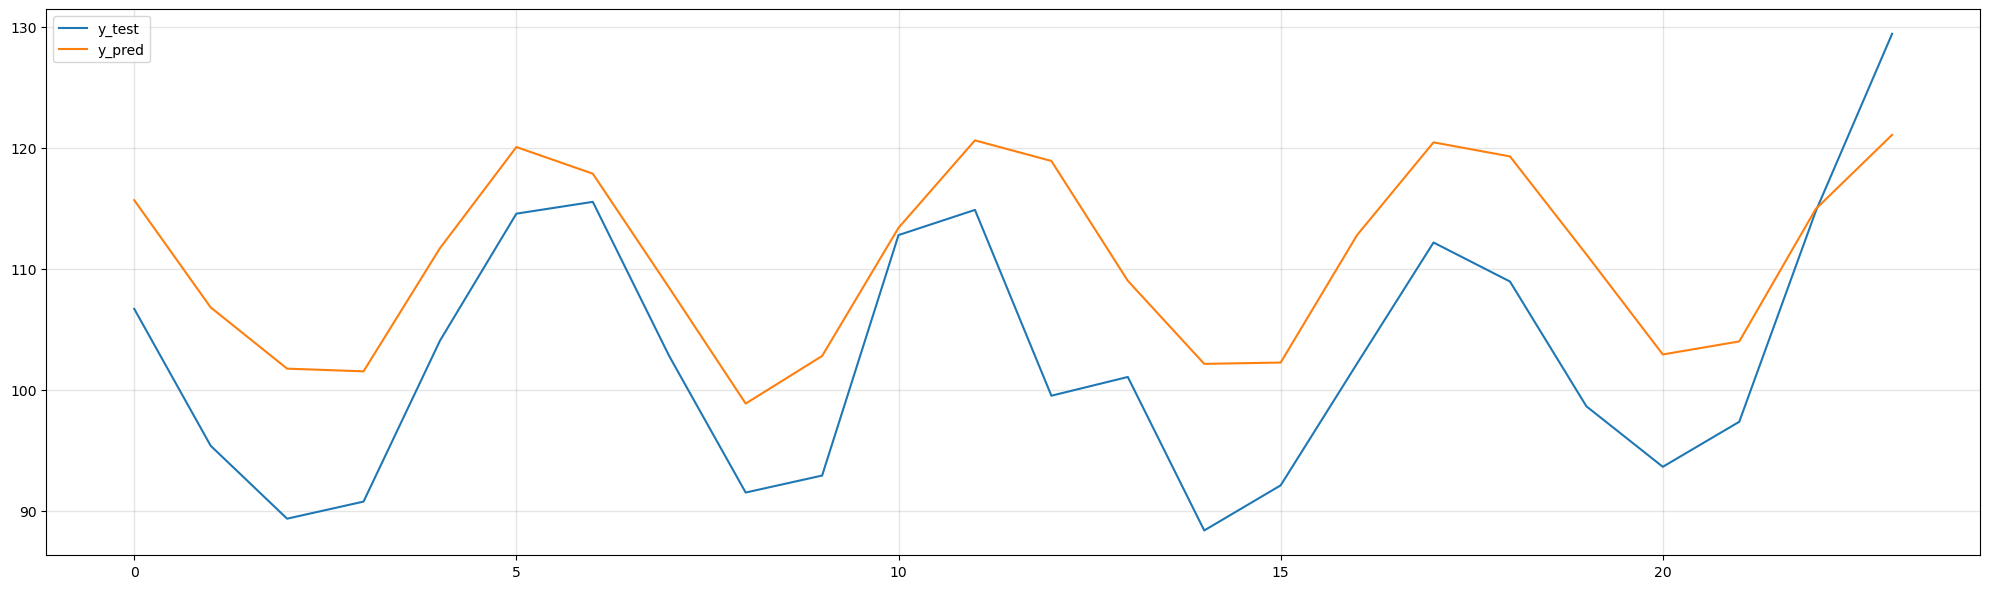

In [9]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test[:-2], y_test[:-2]), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler='ReduceLROnPlateau')
y_pred_cs = model.predict(x_test[-2:])
print(f"r2: {r2_score(y_test[-2:].T, y_pred_cs.T)}")
print(f"mae: {mean_absolute_error(y_test[-2:], y_pred_cs)}")
print(f"mape: {mean_absolute_percentage_error(y_test[-2:], y_pred_cs)}")
a = plot2d(y_test[-2:], y_pred_cs, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))